In [1]:
%cd /Users/giuseppeiannone/mathematical-modelling-for-neuroscience/

/Users/giuseppeiannone/mathematical-modelling-for-neuroscience


In [2]:
import pandas as pd

from utils import *

/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# We import the dataset for the drifting and static data
dataset_drifting = pd.read_parquet('./ourdata/df_drifting_session_757216464.parquet')
dataset_static = pd.read_parquet('./ourdata/df_static_session_757216464.parquet')

We now start with the analysis in the Drifting case

In [7]:
dataset_drifting

,stimulus_presentation_id,area,temporal_frequency,orientation,active
0,3798,APN,1.0,90.0,1
1,3798,CA1,1.0,90.0,1
2,3798,CA3,1.0,90.0,0
3,3798,DG,1.0,90.0,1
4,3798,Eth,1.0,90.0,0
...,...,...,...,...,...
13785,49432,VISal,8.0,180.0,1
13786,49432,VISam,8.0,180.0,1
13787,49432,VISl,8.0,180.0,0
13788,49432,VISp,8.0,180.0,0


In this case the features will be 'temporal_frequency' and 'orientation'.

In [8]:
features_drifting = ['temporal_frequency', 'orientation']

We now check which areas of the brain are in the drifting case.

In [9]:
dataset_drifting['area'].unique()

array(['APN', 'CA1', 'CA3', 'DG', 'Eth', 'LGd', 'LGv', 'LP', 'MB', 'MGm',
       'MRN', 'NOT', 'PO', 'ProS', 'SGN', 'SUB', 'TH', 'VIS', 'VISal',
       'VISam', 'VISl', 'VISp', 'VISrl'], dtype=object)

The number of areas of the brain are useful in the analyisis when we try to do clustering,. so we save them.

In [10]:
n_classes = len(dataset_drifting['area'].unique())

## Clustering

We now plot the feature space of the dataset

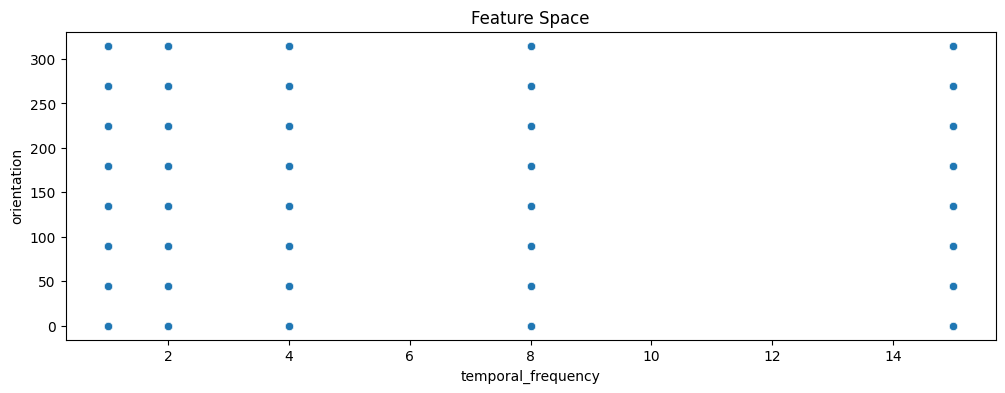

In [11]:
plot_feature_space(dataset_drifting, x_col=features_drifting[0], y_col=features_drifting[1], title='Feature Space')

We  try to use two unsupervised algorithms to cluster the data (KMeans and and Hierarchical Clustering).
In this algorithm we can fix apriori the number of clusters, so we fix it equal to the number of areas of the brain, since we would like to see if the algorithm is able to cluster the features in the same way as the areas of the brain.
As the feature space has few elements and is rather regular, we do not expect unsupervised algorithms to work effectively.


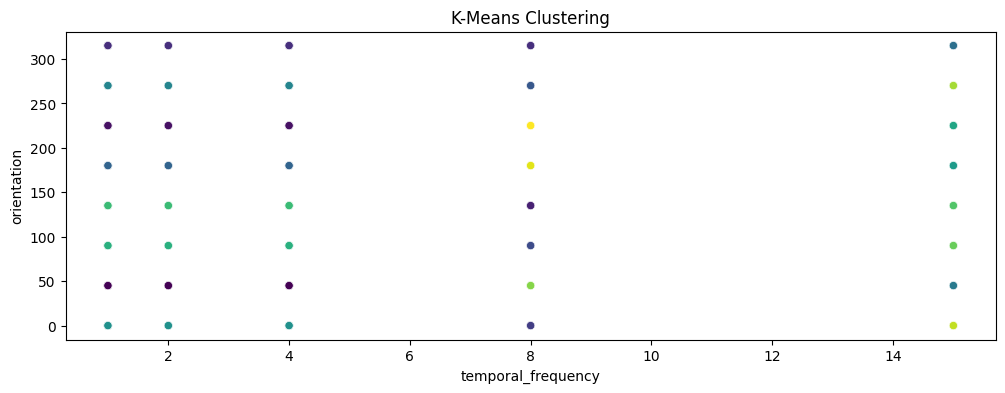

,stimulus_presentation_id,area,temporal_frequency,orientation,active,KMeans_Cluster
0,3798,APN,1.0,90.0,1,14
1,3798,CA1,1.0,90.0,1,14
2,3798,CA3,1.0,90.0,0,14
3,3798,DG,1.0,90.0,1,14
4,3798,Eth,1.0,90.0,0,14
...,...,...,...,...,...,...
13785,49432,VISal,8.0,180.0,1,21
13786,49432,VISam,8.0,180.0,1,21
13787,49432,VISl,8.0,180.0,0,21
13788,49432,VISp,8.0,180.0,0,21


In [12]:
apply_kmeans_clustering(dataset_drifting, n_clusters=n_classes, x_col=features_drifting[0], y_col=features_drifting[1])

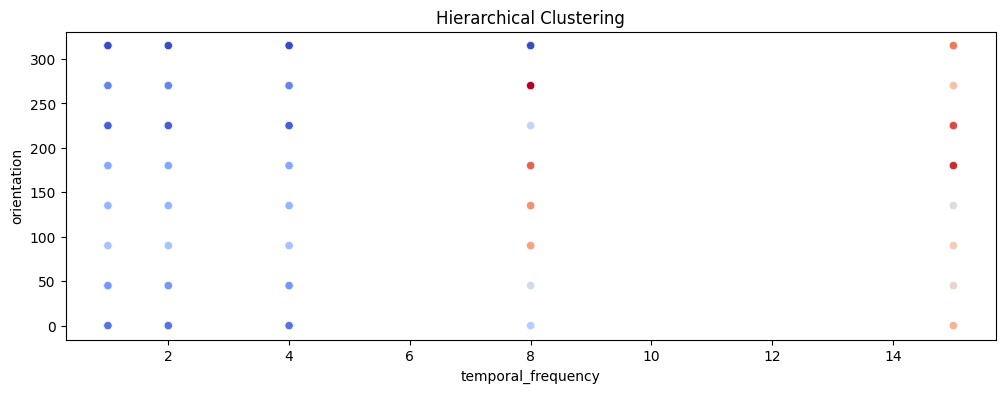

,stimulus_presentation_id,area,temporal_frequency,orientation,active,KMeans_Cluster,Hierarchical_Cluster
0,3798,APN,1.0,90.0,1,14,7
1,3798,CA1,1.0,90.0,1,14,7
2,3798,CA3,1.0,90.0,0,14,7
3,3798,DG,1.0,90.0,1,14,7
4,3798,Eth,1.0,90.0,0,14,7
...,...,...,...,...,...,...,...
13785,49432,VISal,8.0,180.0,1,21,19
13786,49432,VISam,8.0,180.0,1,21,19
13787,49432,VISl,8.0,180.0,0,21,19
13788,49432,VISp,8.0,180.0,0,21,19


In [13]:
apply_hierarchical_clustering(dataset_drifting, n_clusters=n_classes, x_col=features_drifting[0], y_col=features_drifting[1])

It's interesting to note that the KMeans algorith and the Hierarchical Clustering algorithm give different results, but we don't know which one is the best in clustering different areas of the brain. So we check it

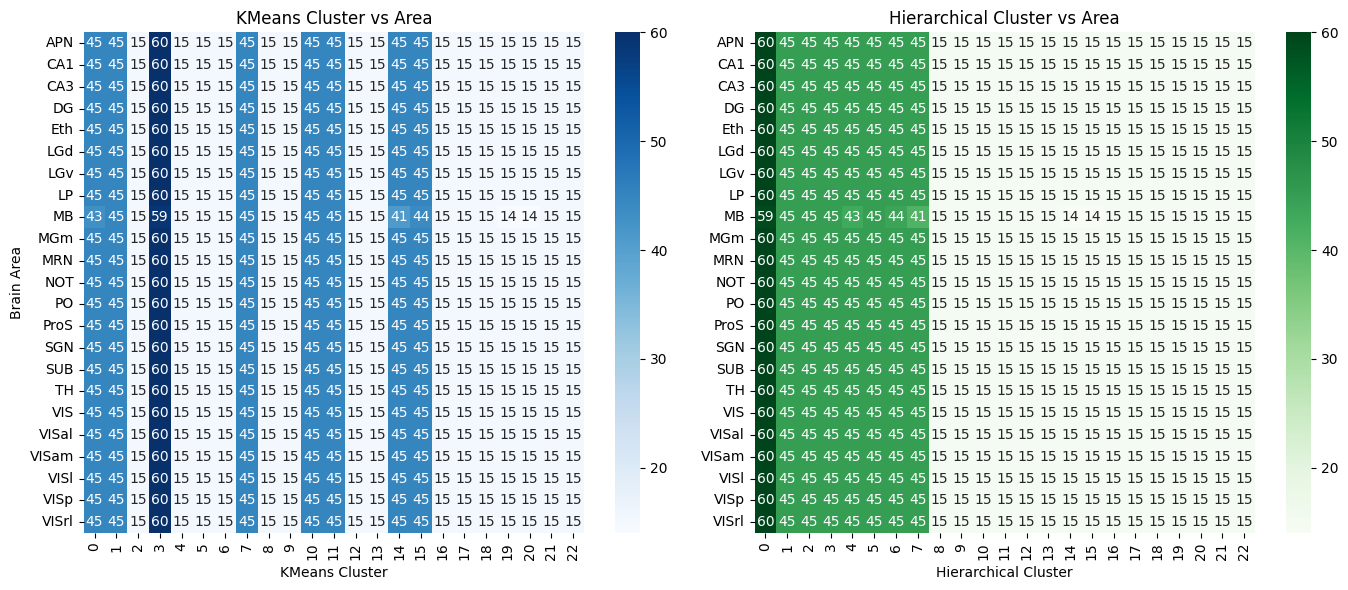

In [14]:
plot_area_cluster_heatmaps(dataset_drifting)

As expected, clustering algorithms do not work well in this case, as the feature space is too regular, so each cluster will contain exactly the same number of elements for each area of the brain.
We need to try a supervised algorithm to see if it can find if some combinations of features are predictive of the activation of a specific area of the brain.

## Supervised classification: XGBoost

We will train a XGBoost classifier for each area of the brain. The classifier will be trained on the features 'temporal_frequency' and 'orientation' and will predict the activation of the area of the brain.

We choose to train different models for each area of the brain, because we think that the features that are predictive of the activation of an area of the brain may be different for each area.

Moreover we will train a model only if the area of the brain is not always activated (or disactivated), otherwise the model would be useless.

In [15]:
models_drifting, results_drifting, label_encoder = train_area_models(dataset_drifting, features=features_drifting, label_col='active', area_col='area')

Training model for area: APN
Training model for area: CA1
Training model for area: CA3
Training model for area: DG
Training model for area: Eth
Training model for area: LGd
Training model for area: LGv
Training model for area: LP
Training model for area: MB
Training model for area: MGm
Training model for area: MRN
Skipping area MRN — only one class present: [1]
Training model for area: NOT
Training model for area: PO
Training model for area: ProS
Training model for area: SGN
Training model for area: SUB
Training model for area: TH
Training model for area: VIS
Training model for area: VISal
Training model for area: VISam
Training model for area: VISl
Training model for area: VISp
Training model for area: VISrl


Classification Report for Area: APN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.82      1.00      0.90        99

    accuracy                           0.82       120
   macro avg       0.41      0.50      0.45       120
weighted avg       0.68      0.82      0.75       120


Classification Report for Area: CA1
              precision    recall  f1-score   support

           0       0.58      0.61      0.59        62
           1       0.56      0.52      0.54        58

    accuracy                           0.57       120
   macro avg       0.57      0.57      0.56       120
weighted avg       0.57      0.57      0.57       120


Classification Report for Area: CA3
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       106
           1       0.00      0.00      0.00        14

    accuracy                           0.88       120
   macro avg      

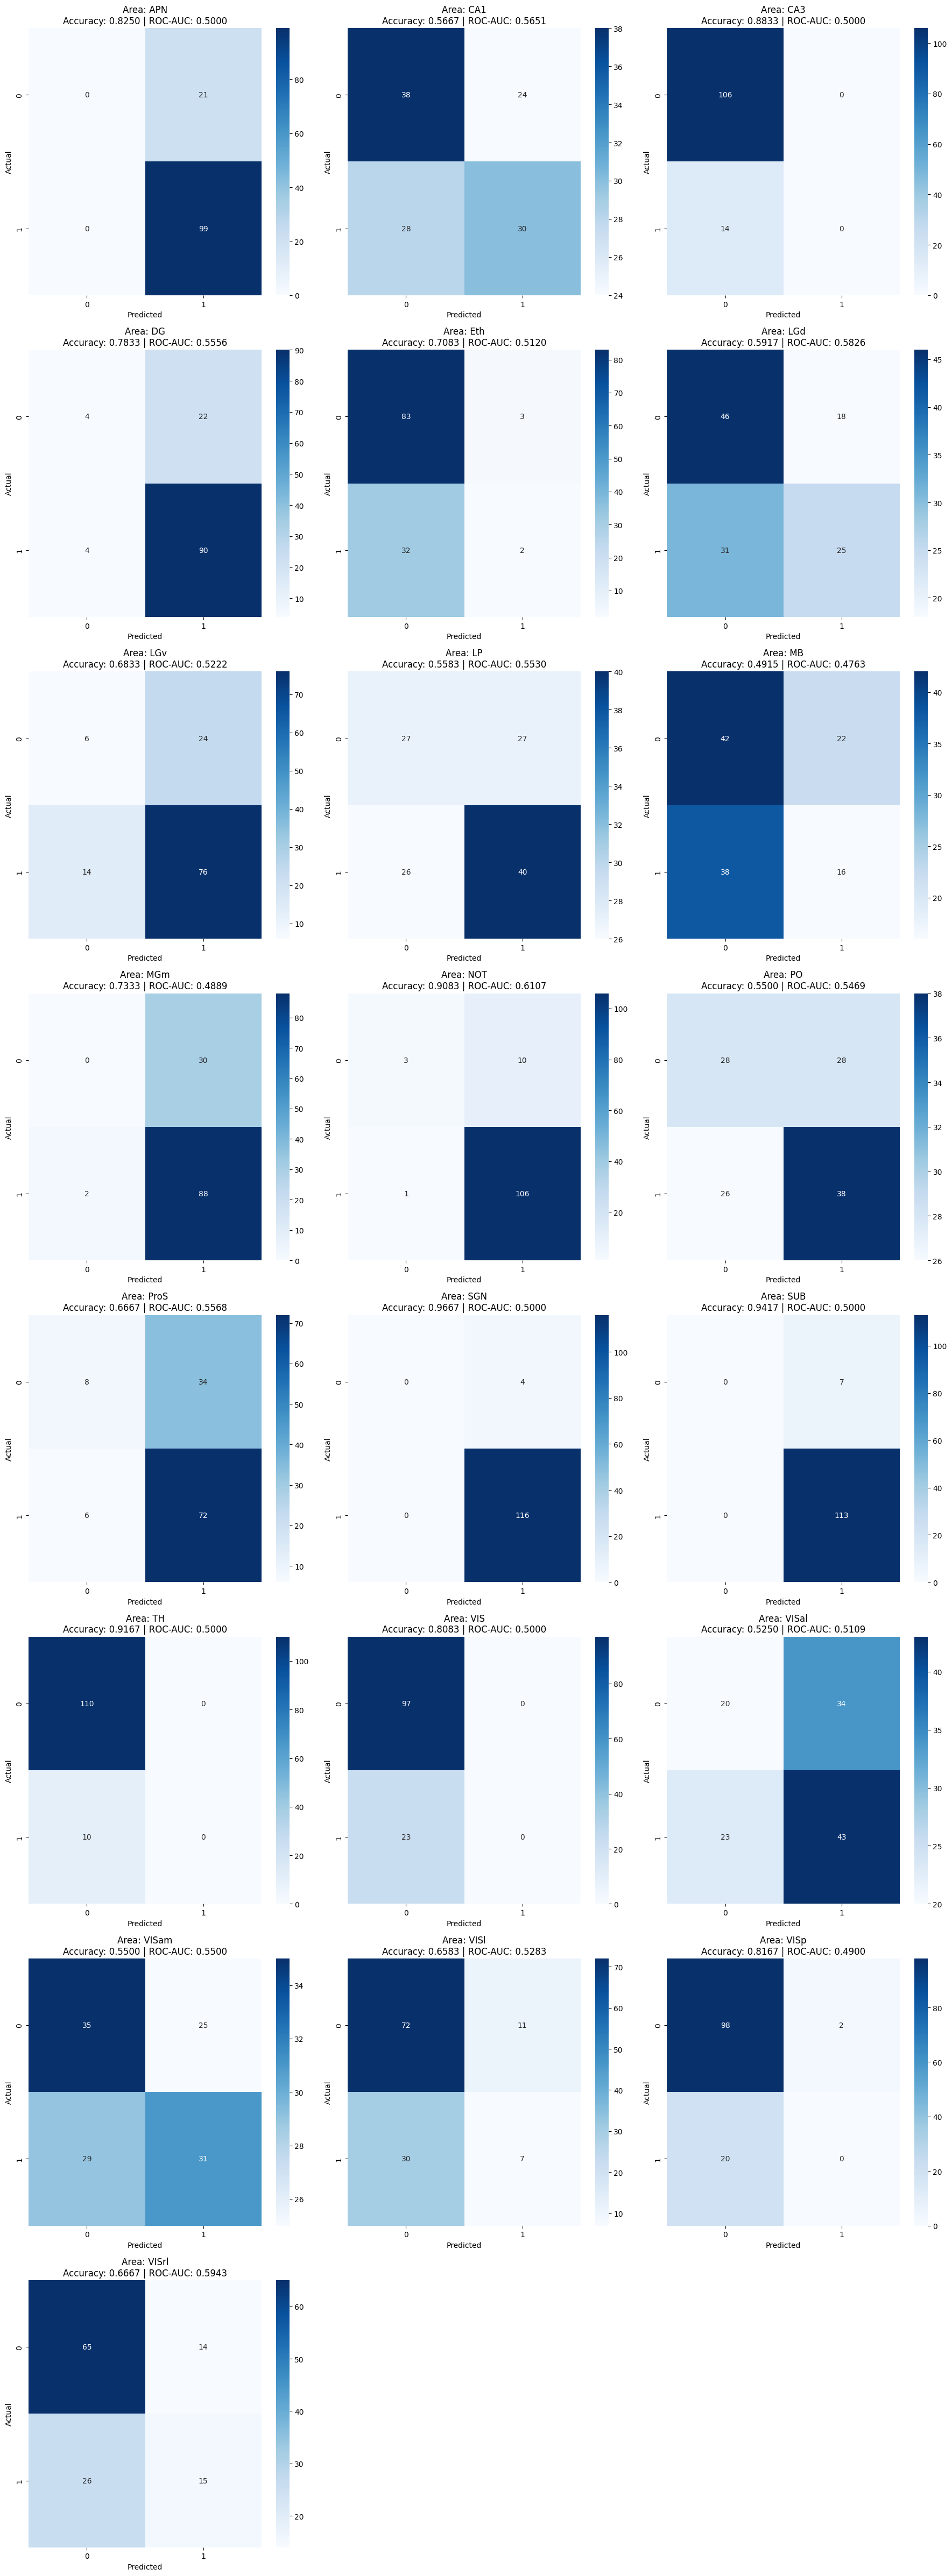

In [16]:
evaluate_and_plot_results(results_drifting, label_encoder=label_encoder)

In [17]:
compare_with_baseline(results_drifting)

Area: APN
Model Accuracy: 0.8250
Baseline (Most Frequent Class) Accuracy: 0.8250
⚠️ Warning: Model is not performing better than the baseline.

Area: CA1
Model Accuracy: 0.5667
Baseline (Most Frequent Class) Accuracy: 0.5167
✅ Model is performing better than the baseline.

Area: CA3
Model Accuracy: 0.8833
Baseline (Most Frequent Class) Accuracy: 0.8833
⚠️ Warning: Model is not performing better than the baseline.

Area: DG
Model Accuracy: 0.7833
Baseline (Most Frequent Class) Accuracy: 0.7833
⚠️ Warning: Model is not performing better than the baseline.

Area: Eth
Model Accuracy: 0.7083
Baseline (Most Frequent Class) Accuracy: 0.7167
⚠️ Warning: Model is not performing better than the baseline.

Area: LGd
Model Accuracy: 0.5917
Baseline (Most Frequent Class) Accuracy: 0.5333
✅ Model is performing better than the baseline.

Area: LGv
Model Accuracy: 0.6833
Baseline (Most Frequent Class) Accuracy: 0.7500
⚠️ Warning: Model is not performing better than the baseline.

Area: LP
Model Accura

{}

Now we do the same analysis for the Static Gratings

In [18]:
dataset_static

,stimulus_presentation_id,area,spatial_frequency,orientation,active
0,49434,APN,0.32,0.0,1
1,49434,CA1,0.32,0.0,1
2,49434,CA3,0.32,0.0,1
3,49434,DG,0.32,0.0,1
4,49434,Eth,0.32,0.0,1
...,...,...,...,...,...
122948,70389,VISal,0.04,150.0,1
122949,70389,VISam,0.04,150.0,0
122950,70389,VISl,0.04,150.0,0
122951,70389,VISp,0.04,150.0,1


In [19]:
features_static = ['spatial_frequency', 'orientation']

In [20]:
dataset_static['area'].unique()

array(['APN', 'CA1', 'CA3', 'DG', 'Eth', 'LGd', 'LGv', 'LP', 'MB', 'MGm',
       'MRN', 'NOT', 'PO', 'ProS', 'SGN', 'SUB', 'TH', 'VIS', 'VISal',
       'VISam', 'VISl', 'VISp', 'VISrl'], dtype=object)

In [21]:
n_classes = len(dataset_static['area'].unique())

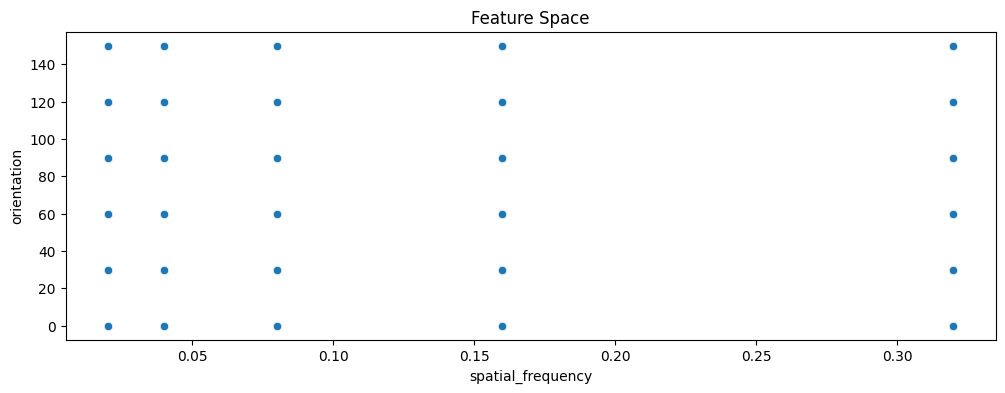

In [22]:
plot_feature_space(dataset_static, x_col=features_static[0], y_col=features_static[1], title='Feature Space')

In [23]:
dataset_static_clustering = dataset_static.sample(30000)

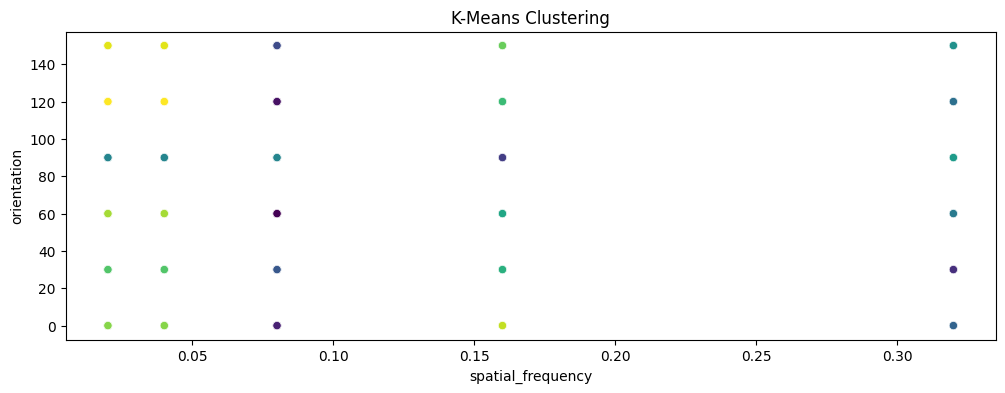

,stimulus_presentation_id,area,spatial_frequency,orientation,active,KMeans_Cluster
70014,56622,LP,0.04,30.0,1,16
54390,55802,LGv,0.32,120.0,1,8
96267,69108,MGm,0.32,0.0,1,7
97757,69187,PO,0.08,60.0,0,0
31959,50856,VIS,0.02,150.0,1,21
...,...,...,...,...,...,...
35133,51002,VIS,0.08,0.0,1,2
122292,70359,LGd,0.04,120.0,1,22
62946,56246,CA3,0.16,150.0,1,17
64008,56301,LGd,0.08,0.0,1,2


In [24]:
apply_kmeans_clustering(dataset_static_clustering, n_clusters=n_classes, x_col=features_static[0], y_col=features_static[1])

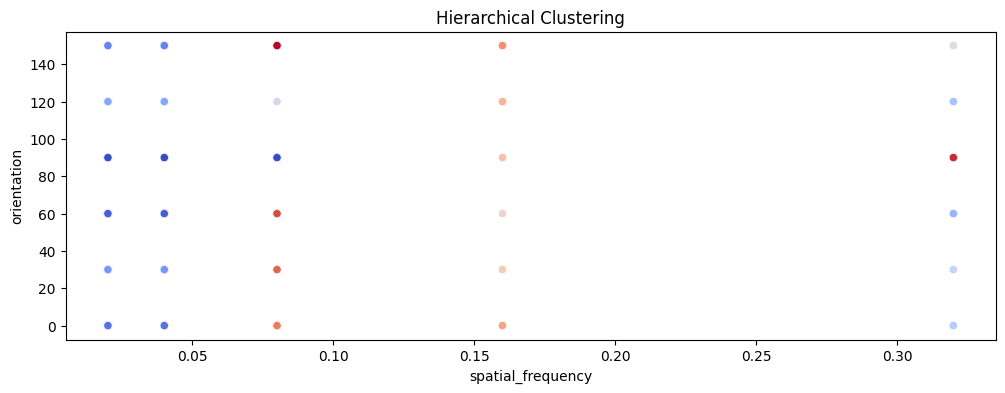

,stimulus_presentation_id,area,spatial_frequency,orientation,active,KMeans_Cluster,Hierarchical_Cluster
70014,56622,LP,0.04,30.0,1,16,4
54390,55802,LGv,0.32,120.0,1,8,7
96267,69108,MGm,0.32,0.0,1,7,8
97757,69187,PO,0.08,60.0,0,0,20
31959,50856,VIS,0.02,150.0,1,21,3
...,...,...,...,...,...,...,...
35133,51002,VIS,0.08,0.0,1,2,18
122292,70359,LGd,0.04,120.0,1,22,5
62946,56246,CA3,0.16,150.0,1,17,17
64008,56301,LGd,0.08,0.0,1,2,18


In [25]:
apply_hierarchical_clustering(dataset_static_clustering, n_clusters=n_classes, x_col=features_static[0], y_col=features_static[1])

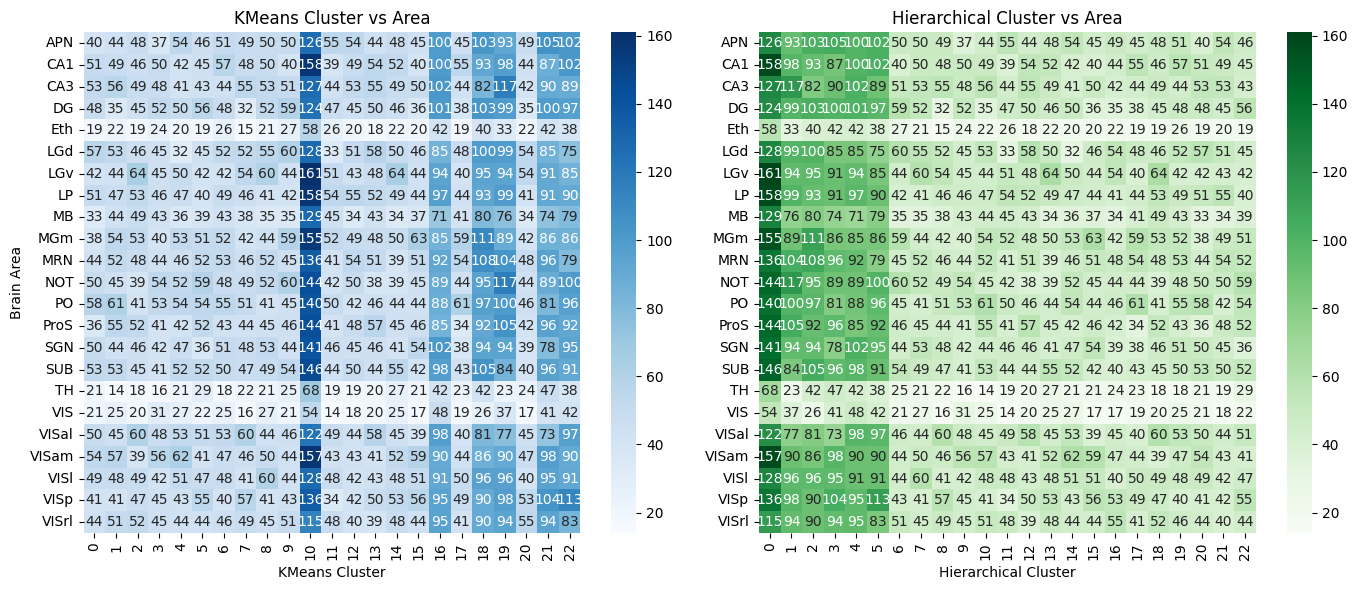

In [26]:
plot_area_cluster_heatmaps(dataset_static_clustering)

In [27]:
models_static, results_static, label_encoder = train_area_models(dataset_static, features=features_static, label_col='active', area_col='area')

Training model for area: APN
Training model for area: CA1
Training model for area: CA3
Training model for area: DG
Training model for area: Eth
Training model for area: LGd
Training model for area: LGv
Training model for area: LP
Training model for area: MB
Training model for area: MGm
Training model for area: MRN
Skipping area MRN — only one class present: [1]
Training model for area: NOT
Training model for area: PO
Training model for area: ProS
Training model for area: SGN
Skipping area SGN — insufficient samples for stratified split (class counts: {1: 5806, 0: 1})
Training model for area: SUB
Training model for area: TH
Training model for area: VIS
Training model for area: VISal
Training model for area: VISam
Training model for area: VISl
Training model for area: VISp
Training model for area: VISrl


Classification Report for Area: APN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      1.00      1.00      1159

    accuracy                           1.00      1162
   macro avg       0.50      0.50      0.50      1162
weighted avg       0.99      1.00      1.00      1162


Classification Report for Area: CA1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.99      1.00      1.00      1152

    accuracy                           0.99      1162
   macro avg       0.50      0.50      0.50      1162
weighted avg       0.98      0.99      0.99      1162


Classification Report for Area: CA3
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.85      1.00      0.92       985

    accuracy                           0.85      1161
   macro avg      

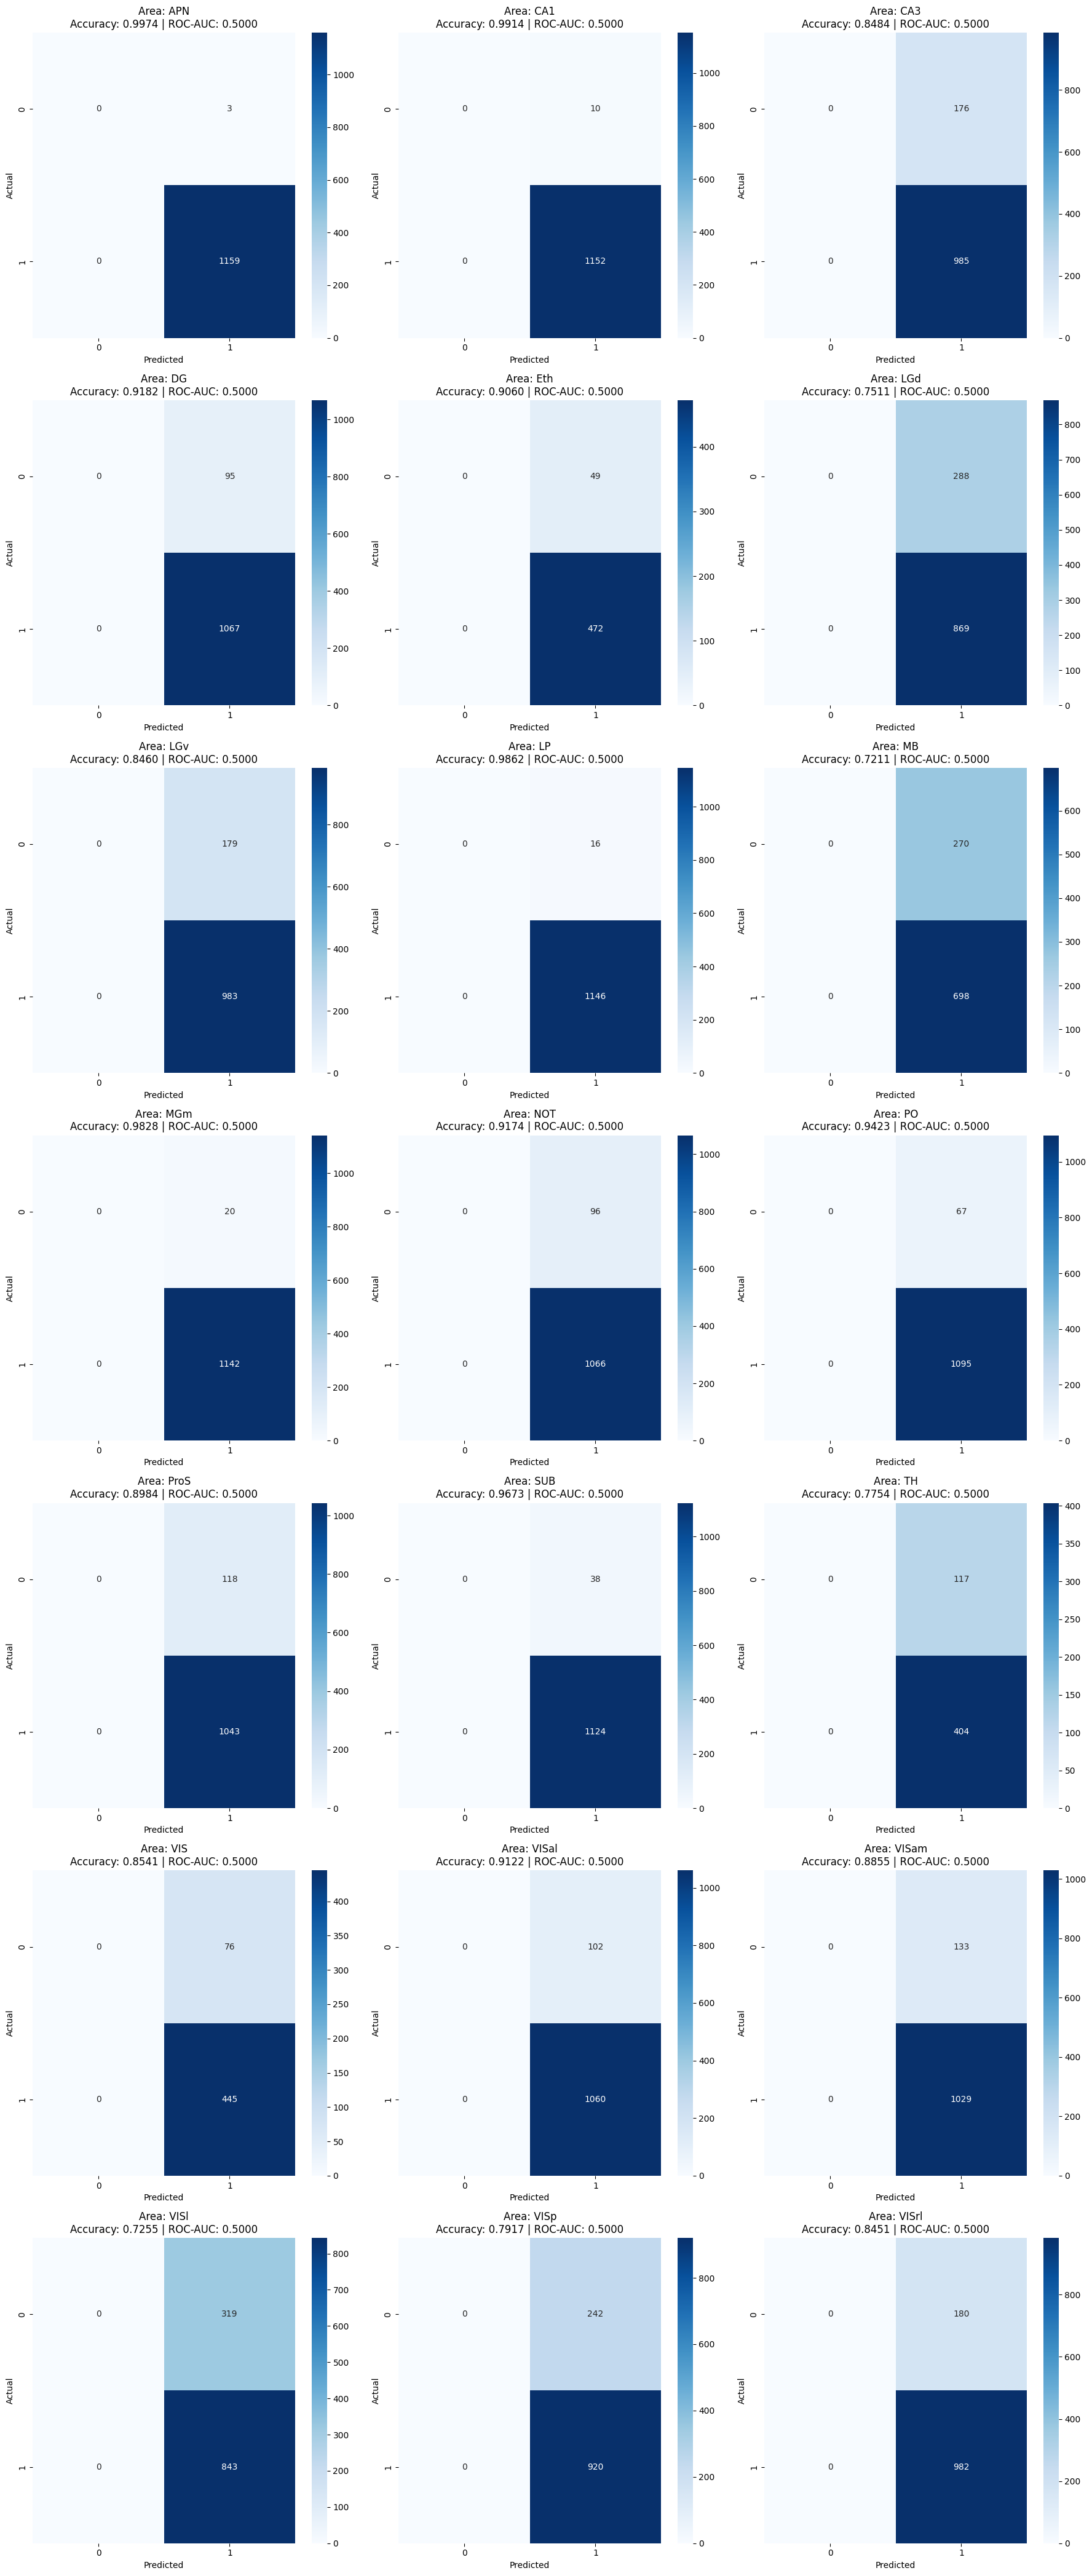

In [28]:
evaluate_and_plot_results(results_static, label_encoder=label_encoder)

In [29]:
compare_with_baseline(results_static)

Area: APN
Model Accuracy: 0.9974
Baseline (Most Frequent Class) Accuracy: 0.9974
⚠️ Warning: Model is not performing better than the baseline.

Area: CA1
Model Accuracy: 0.9914
Baseline (Most Frequent Class) Accuracy: 0.9914
⚠️ Warning: Model is not performing better than the baseline.

Area: CA3
Model Accuracy: 0.8484
Baseline (Most Frequent Class) Accuracy: 0.8484
⚠️ Warning: Model is not performing better than the baseline.

Area: DG
Model Accuracy: 0.9182
Baseline (Most Frequent Class) Accuracy: 0.9182
⚠️ Warning: Model is not performing better than the baseline.

Area: Eth
Model Accuracy: 0.9060
Baseline (Most Frequent Class) Accuracy: 0.9060
⚠️ Warning: Model is not performing better than the baseline.

Area: LGd
Model Accuracy: 0.7511
Baseline (Most Frequent Class) Accuracy: 0.7511
⚠️ Warning: Model is not performing better than the baseline.

Area: LGv
Model Accuracy: 0.8460
Baseline (Most Frequent Class) Accuracy: 0.8460
⚠️ Warning: Model is not performing better than the base

{}